# Обучение модели

#### Параметры
- Данные: googlemaps-dataset-140k
- Размер изображения: 128 x 128

In [19]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

#### Считываение изображений и координат

In [20]:
PATH_NEGATIVE_V2 = '/home/jupyter/datasphere/datasets/googlemaps-dataset-140k/googlemaps_data/negative_v2'
PATH_NEGATIVE_V3 = '/home/jupyter/datasphere/datasets/googlemaps-dataset-140k/googlemaps_data/negative_v3'

In [21]:
IMG_FILES_V2 = [
    f'{PATH_NEGATIVE_V2}/negative_samples_v2/{filename}'
    for filename in os.listdir(f'{PATH_NEGATIVE_V2}/negative_samples_v2')
    if '.png' in filename
]
IMG_FILES_V3 = [
    f'{PATH_NEGATIVE_V3}/negative_samples_v3/{filename}'
    for filename in os.listdir(f'{PATH_NEGATIVE_V3}/negative_samples_v3')
    if '.png' in filename
]

In [22]:
IMG_FILES = IMG_FILES_V2 + IMG_FILES_V3

In [23]:
# FULL_COORDS_V2 = pd.read_csv(f'{IMG_FILES_V2}/negative_coords_v2.csv')
# FULL_COORDS_V3 = pd.read_csv(f'{IMG_FILES_V3}/negative_coords_v3.csv')

#### Создание датасета

In [24]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [25]:
class ArchDataset(Dataset):
    
    def __init__(self, transform=None, filenames=IMG_FILES, coords=None):
        self.transform = transform
        self.filenames = filenames
        self.coords = coords

    def __len__(self):
        return len(self.filenames)
    
    def get_coords(self, idx):
        if self.coords:
            return self.coords[idx]
        else:
            raise NotImplemented()

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [26]:
dataset = ArchDataset(transform=transform)

loader = DataLoader(
    dataset, 
    shuffle=True, 
    batch_size=256
)

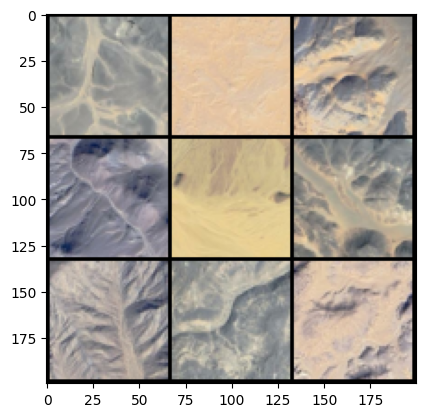

In [27]:
plt.imshow(make_grid([(dataset[i] + 1) / 2 for i in range(9)], nrow=3).permute(1,2,0));

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [29]:
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def sample(self, size):
        sample = torch.randn(size, self.nz).to(self.device)
        return self.decode(sample)
    
    @property
    def device(self): return next(self.parameters()).device

In [31]:
model = VAE(isize=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, min_lr=1e-6)

#### Чекпоинты

In [32]:
version = '001'

In [33]:
checkpoint_path = f'vae64_checkpoints/model_{version}.pt'
optimizer_path = f'vae64_checkpoints/optim_{version}.pt'

In [15]:
# prev_checkpoint_path = ...
# model.load_state_dict(torch.load(prev_checkpoint_path))

#### Обучение

In [ ]:
# pip install wandb

In [34]:
import wandb

wandb.login(key='514eb1383ebf19dfe33c9834438026c917300873')
wandb.init( project='arch_googlemaps_vae', name='vae64_v1')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [35]:
def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

In [36]:
def train_epoch(pbar, num_epoch):
    
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    
    for batch_idx, data in enumerate(loader):
        
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        
        loss.backward()
        optimizer.step()
        scheduler.step(loss.item())
        
        wandb.log({'loss': loss.item()})
        
        train_loss += loss.item()
        train_mse += mse_loss.item()
        train_kld += kld_loss.item()
        
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)

        if batch_idx % 50 == 0:
            
            torch.save(model.state_dict(), checkpoint_path)
            torch.save(optimizer.state_dict(), optimizer_path)
            
            with torch.no_grad():
                sample_img_file = f'vae64_samples/sample_e{str(num_epoch).zfill(2)}_{str(batch_idx).zfill(3)}.png'
                utils.save_image(
                    model.sample(16).cpu().data,
                    sample_img_file,
                    normalize=True,
                    nrow=4,
                )
                wandb.log({'sample': wandb.Image(Image.open(sample_img_file))})
            

In [ ]:
epochs = 10

with tqdm(total=epochs * len(loader), desc=f"[KL: ?] [MSE: ?]") as pbar:
  for epoch in range(11, 21):
      train_epoch(pbar, epoch)
      # with torch.no_grad():
      #     sample = model.sample(64).cpu()
      #     log_img = make_grid(sample)

[KL: 55.32] [MSE:  579.48]:  76%|███████▋  | 4179/5470 [1:06:49<20:22,  1.06it/s]

Смотрим, как модель генерирует фото пустыни

In [ ]:
with torch.no_grad():
    sample = model.sample(4).cpu()
    log_img = make_grid(sample)
plt.figure(figsize=(15, 15))
plt.imshow((log_img.permute(1,2,0) - log_img.min()) / (log_img.max() - log_img.min()));

Считаем lpips

In [ ]:
import lpips

In [ ]:
loss_fn_alex = lpips.LPIPS(net='alex')

In [ ]:
img_neg_0 = Image.open(f'/Users/nadys/python_projects/archaeology-project/data_retrieval/yandexmaps_data/negative_sampels/img000000.png')
img_neg_1 = Image.open(f'/Users/nadys/python_projects/archaeology-project/data_retrieval/yandexmaps_data/negative_sampels/img000001.png')
img_neg_2 = Image.open(f'/Users/nadys/python_projects/archaeology-project/data_retrieval/yandexmaps_data/negative_sampels/img000002.png')
img_pos_0 = Image.open(f'/Users/nadys/python_projects/archaeology-project/data_retrieval/yandexmaps_data/positive_samples/Abbad.png')
img_pos_1 = Image.open(f'/Users/nadys/python_projects/archaeology-project/data_retrieval/yandexmaps_data/positive_samples/Abiyad.png')
img_pos_2 = Image.open(f'/Users/nadys/python_projects/archaeology-project/data_retrieval/yandexmaps_data/positive_samples/Asyut.png')

In [ ]:
class ArchPositives(Dataset):
    def __init__(self, transform=None):
        self.root_dir = '/Users/nadys/python_projects/archaeology-project/data_retrieval/yandexmaps_data/positive_samples'
        self.transform = transform
        self.images = [s for s in os.listdir(self.root_dir) if s.endswith('png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        return image

positives_dataset = ArchPositives(transform=transform)

In [ ]:
positives_loader = torch.utils.data.DataLoader(
    positives_dataset, 
    batch_size=64, 
    shuffle=False
)

In [ ]:
def load_image(names):
    imgs = []
    for name in names:
        img = transform(Image.open(name).convert('RGB'))
        imgs.append(img)
    return imgs

def align_image(img):
    return (img - img.min()) / (img.max() - img.min())

def draw_image(imgs):
    fig, axes = plt.subplots(ncols=len(imgs) , figsize=(len(imgs) * 2, 2))

    if len(imgs) == 1:
        img = imgs[0]
        axes.imshow(align_image(img).permute(1, 2, 0))
    else:
        for i, img in enumerate(imgs): 
            axes[i].imshow(align_image(img).permute(1, 2, 0))
    plt.show()

other = load_image(['cat.png'])
draw_image(other)

In [ ]:
rec0 = model(positives_dataset[0].to(device)[None, :])[0]
loss_fn_alex(positives_dataset[0].to('cpu'), rec0.to('cpu'))

In [ ]:
rec0 = model(positives_dataset[1].to(device)[None, :])[0]
loss_fn_alex(positives_dataset[1].to('cpu'), rec0.to('cpu'))

In [ ]:
rec0 = model(dataset[0].to(device)[None, :])[0]
loss_fn_alex(dataset[0].to('cpu'), rec0.to('cpu'))

In [ ]:
rec0 = model(dataset[1].to(device)[None, :])[0]
loss_fn_alex(dataset[1].to('cpu'), rec0.to('cpu'))

In [ ]:
@torch.no_grad()
def apply_model(n_neg=2, n_pos=2, other_image_names=[]):
    dataset_examples = torch.stack([dataset[i].to(device) for i in np.random.randint(0, 100, n_neg)], dim=0)
    positive_examples = torch.stack([positives_dataset[i].to(device) for i in np.random.randint(0, 100, n_pos)], dim=0)
    other_examples =  torch.stack([anomaly.to(device) for anomaly in load_image(other_image_names)], dim=0)

    examples = torch.concat((dataset_examples, positive_examples, other_examples), dim=0)
    
    reconstructions = model(examples)[0]
    mus = model(examples)[1]
    print(mus.shape)
    sigmas = model(examples)[2]
    print(sigmas.shape)
    return examples, reconstructions


@torch.no_grad()
def anomaly_detection(examples, reconstructions):
    ncols = len(examples)
    nrows = 2
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4))

    data = torch.cat([examples[None], reconstructions[None]], dim=0)
    print(data.shape)
    for row in range(nrows):
        for col in range(ncols):
            if row == 1:
                similarity = loss_fn_alex(data[row - 1, col].to('cpu'), data[row, col].to('cpu'))[0, 0, 0, 0].item()
                axes[row, col].set_title(f'lpips: {np.round(similarity, 2)}')
            
            axes[row, col].imshow(align_image(data[row, col].to('cpu')).permute(1, 2, 0))
            axes[row, col].axis('off')
    plt.show()

In [ ]:
examples, reconstructions = apply_model(n_pos=3, n_neg=3, other_image_names=['cat.png'])
anomaly_detection(examples, reconstructions)